# Two-Derivative Runge-Kutta Methods
## Table of Contens
## 1) Two-Derivative Runge-Kutta Method as a new AbstractTimeIntegrationMethod
## 2) Elementary Weight of the Two-Derivative Runge-Kutta Method
## 3) B-Series of the Two-Derivative Runge-Kutta Method
## 4) Example: B-Series for an explicit two-derivative Runge-Kutta method
## 5) Repition of Symplecticity (functions taken from ".ipynb". Go to the file for further information)
## 6) Repition of Symmetry (functions taken from ".ipynb". Go to the file for further information)
## 7) Example: Analyzing a two-derivative Runge-Kutta method
$\color{blue}{\text{Note: Part 5) and 6) is a repition of the functions needed for checking symmetry and symplecticity.}}$
$\color{blue}{\text{I need the functions for analyzing a specific method in Part 7).}}$
$\color{blue}{\text{For further information about checking the symmetry and the symplecticity of a method please have a look at the files ...}}$

First, we need to import the packages that will be used in the following code.

In [1]:
import Pkg; Pkg.add("BSeries")
import Pkg; Pkg.add("LinearAlgebra")
import Pkg; Pkg.add("RootedTrees")
import Pkg; Pkg.add("OrdinaryDiffEq")
import Pkg; Pkg.add("NLsolve")
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("LaTeXStrings")
# The functions "elementary_weight" and "derivative_weight" also need to be imported to define them new for these methods 
import RootedTrees.elementary_weight
import RootedTrees.derivative_weight

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Chan

In [2]:
using BSeries
using LinearAlgebra
using RootedTrees
using OrdinaryDiffEq
using NLsolve
using Plots
using LaTeXStrings

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 1) Two-Derivative Runge-Kutta Method as a new AbstractTimeIntegrationMethod
Note: This is mainly copied from the AdditiveRungeKuttaMethod from Julia package "bseries.jl". 

In [3]:
abstract type AbstractTimeIntegrationMethod end

In [4]:
struct TwoDerivativeRungeKuttaMethod{T, RKm <: AbstractVector{<:RungeKuttaMethod{T}}} <:
       AbstractTimeIntegrationMethod
    rkm::RKm
end

In [5]:
function TwoDerivativeRungeKuttaMethod(rkm) # if not all RK methods use the same eltype
    T = mapreduce(eltype, promote_type, rkm)
    As = map(rk -> T.(rk.A), rkm)
    bs = map(rk -> T.(rk.b), rkm)
    cs = map(rk -> T.(rk.c), rkm)
    TwoDerivativeRungeKuttaMethod(As, bs, cs)
end

TwoDerivativeRungeKuttaMethod

In [6]:
function TwoDerivativeRungeKuttaMethod(As, bs, cs = map(A -> vec(sum(A, dims = 2)), As))
    rkm = map(RungeKuttaMethod, As, bs, cs)
    TwoDerivativeRungeKuttaMethod(rkm)
end

TwoDerivativeRungeKuttaMethod

In [7]:
Base.eltype(tdrk::TwoDerivativeRungeKuttaMethod{T}) where {T} = T

In [8]:
function Base.show(io::IO, tdrk::TwoDerivativeRungeKuttaMethod)
    print(io, "TwoDerivativeRungeKuttaMethod{", eltype(tdrk), "} with methods\n")
    for (idx, rk) in enumerate(tdrk.rkm)
        print(io, idx, ". ")
        show(io, rk)
    end
end

# 2) Elementary Weight of the Two-Derivative Runge-Kutta Method
As you can see in my bachelor thesis in section ... we need to define the elementary weight completely new for two-derivative Runge-Kutta methods.
This will be splitted in two parts.

### Part One
Taking a look at section ... in my thesis it is clear that we not only need the 'normal' subtrees of a tree $t$, but also the subtrees of $t$ remaining after removing the tree [1,2] of $t$. Unfortunately, for most of the trees there exist more than one option to remove [1,2] from the tree.
This brings us to the function "specialsubtrees". It returns a vector of all possibilties of specialsubtrees.

In [9]:
function specialsubtrees(t::RootedTree)
    # first we need an overview about the subtrees of t
    thesubtrees = subtrees(t)
    numberofsubtrees = length(thesubtrees)

    # This will be the vector returning all the possibilities of specialsubtrees
    listofspecialsubtrees = []

    # Using recursion we get the vector of all possibilites of specialsubtees
    for i in 1:numberofsubtrees
        thesubsubtrees = subtrees(thesubtrees[i])
        numberofsubsubtrees = length(thesubsubtrees)

        for j in 1:numberofsubtrees
            if j == i
            elseif j > i
                push!(thesubsubtrees, thesubtrees[j])
            else j < i
                pushfirst!(thesubsubtrees, thesubtrees[i-j])
            end
        
        end

        push!(listofspecialsubtrees, thesubsubtrees)
    end

    return listofspecialsubtrees
end

specialsubtrees (generic function with 1 method)

### Part Two
Now we can start to define the functions "elementary_weight" and "derivative_weight".

In [10]:
function elementary_weight(t::RootedTree, tdrk::TwoDerivativeRungeKuttaMethod)
    b1 = (tdrk.rkm)[1].b
    b2 = (tdrk.rkm)[2].b
    # let a be the elementary weight and n the derivative weight
    # Then the elementary weight is calculated by a(t) = b1 * nu(subtrees(t)) + b2 * nu(specialsubtrees(nu))
    dot(b1, derivative_weight(t, tdrk)) + dot(b2, derivative_weight(t, 0, tdrk))
end

elementary_weight (generic function with 6 methods)

Since the elementary weight is calculated as written above, we need two different functions for calculating the elementary weight. The first one calculates it using the subtrees of $t$, the second one using the specialsubtrees of $t$.

In [11]:
function derivative_weight(t::RootedTree, tdrk::TwoDerivativeRungeKuttaMethod)
    A1 = (tdrk.rkm)[1].A
    c1 = (tdrk.rkm)[1].c
    A2 = (tdrk.rkm)[2].A
    c2 = (tdrk.rkm)[2].c

    # This vector has the same length like c1 and c2 do but contains only the element 1
    result1 = zero(c1) .+ one(eltype(c1))

    if t == rootedtree(Int64[]) || t == rootedtree([1])
        return zero(c1) .+ one(eltype(c1))

    else
        # Using recursion we calculate the derivative weight as defined in the thesis 
        subtreesoft = subtrees(t)
        numberofsubtreesoft = length(subtreesoft)
        l = 1
        for n in SubtreeIterator(t)
            tmp = A1 * derivative_weight(subtreesoft[l], tdrk) .+ A2 * derivative_weight(subtreesoft[l], 0, tdrk)
            result1 = result1 .* tmp
            l = l + 1
        end
        return result1
    end
end

derivative_weight (generic function with 5 methods)

In [12]:
function derivative_weight(t::RootedTree, a::Int64, tdrk::TwoDerivativeRungeKuttaMethod)
    A1 = (tdrk.rkm)[1].A
    c1 = (tdrk.rkm)[1].c
    A2 = (tdrk.rkm)[2].A
    c2 = (tdrk.rkm)[2].c
    emptyresult = zero(c2)
    
    if t == rootedtree(Int64[])
        return zero(c1) .+ one(eltype(c1))
    else
        
        relevanttreecombinations = specialsubtrees(t)
        number1 = length(relevanttreecombinations)

        # Using recursion we calculate the derivative weight as defined in the thesis
        for k in 1:number1
            relevantsubtreecombinations = relevanttreecombinations[k]
            number2 = length(relevantsubtreecombinations)
            result2 = zero(c1) .+ one(eltype(c1))

            for m in 1:number2
                step = A1 * derivative_weight(relevantsubtreecombinations[m], tdrk) .+ A2 * derivative_weight(relevantsubtreecombinations[m], 0, tdrk)
                result2 = result2 .* step
            end

            emptyresult = emptyresult .+ result2

        end

        return emptyresult
    end
end

derivative_weight (generic function with 6 methods)

# 3) B-Series of the Two-Derivative Runge-Kutta Method
This is mainly copied from the creation of the B-series of RungeKuttaMethod from the Julia package "bseries.jl".

In [13]:
function bseries(tdrk::TwoDerivativeRungeKuttaMethod, order)
    V_tmp = eltype(tdrk)
    if V_tmp <: Integer
        # If people use integer coefficients, they will likely want to have results
        # as exact as possible. However, general terms are not integers. Thus, we
        # use rationals instead.
        V = Rational{V_tmp}
    else
        V = V_tmp
    end
    series = TruncatedBSeries{RootedTree{Int, Vector{Int}}, V}()

    series[rootedtree(Int[])] = one(V)
    for o in 1:order
        for t in RootedTreeIterator(o)
            #only difference here: we are using the elementary_weight for Two-Derivative Runge-Kutta Methods
            series[copy(t)] = elementary_weight(t, tdrk)
        end
    end

    return series
end

bseries (generic function with 1 method)

In [14]:
function bseries(A::Vector{AbstractMatrix}, b::Vector{AbstractVector}, c::Vector{AbstractVector}, order)
    tdrk = TwoDerivativeRungeKuttaMethod(A, b, c)
    bseries(tdrk, order)
end

bseries (generic function with 2 methods)

# 4) Example: B-Series for an explicit two-derivative Runge-Kutta method
The following example can be found in the paper "On explicit two-derivative Runge-Kutta methods" from R.P.K. Chan and A.Y.J. Tsai (2010)

In [15]:
A1 = [0 0; 1//2 0]
b1 = [1, 0]
A2 = [0 0; 1//8 0]
b2 = [1//6, 1//3]

twostageTDRK = TwoDerivativeRungeKuttaMethod([A1, A2], [b1,b2])

TwoDerivativeRungeKuttaMethod{Rational{Int64}} with methods
1. RungeKuttaMethod{Rational{Int64}} with
A: 2×2 Matrix{Rational{Int64}}:
 0//1  0//1
 1//2  0//1
b: 2-element Vector{Rational{Int64}}:
 1//1
 0//1
c: 2-element Vector{Rational{Int64}}:
 0//1
 1//2
2. RungeKuttaMethod{Rational{Int64}} with
A: 2×2 Matrix{Rational{Int64}}:
 0//1  0//1
 1//8  0//1
b: 2-element Vector{Rational{Int64}}:
 1//6
 1//3
c: 2-element Vector{Rational{Int64}}:
 0//1
 1//8


In [16]:
bseries_twostageTDRK = bseries(twostageTDRK, 5)

TruncatedBSeries{RootedTree{Int64, Vector{Int64}}, Rational{Int64}} with 18 entries:
  RootedTree{Int64}: Int64[]         => 1//1
  RootedTree{Int64}: [1]             => 1//1
  RootedTree{Int64}: [1, 2]          => 1//2
  RootedTree{Int64}: [1, 2, 3]       => 1//6
  RootedTree{Int64}: [1, 2, 2]       => 1//3
  RootedTree{Int64}: [1, 2, 3, 4]    => 1//24
  RootedTree{Int64}: [1, 2, 3, 3]    => 1//12
  RootedTree{Int64}: [1, 2, 3, 2]    => 1//8
  RootedTree{Int64}: [1, 2, 2, 2]    => 1//4
  RootedTree{Int64}: [1, 2, 3, 4, 5] => 0//1
  RootedTree{Int64}: [1, 2, 3, 4, 4] => 0//1
  RootedTree{Int64}: [1, 2, 3, 4, 3] => 1//48
  RootedTree{Int64}: [1, 2, 3, 4, 2] => 1//48
  RootedTree{Int64}: [1, 2, 3, 3, 3] => 1//24
  RootedTree{Int64}: [1, 2, 3, 3, 2] => 1//24
  RootedTree{Int64}: [1, 2, 3, 2, 3] => 1//24
  RootedTree{Int64}: [1, 2, 3, 2, 2] => 1//12
  RootedTree{Int64}: [1, 2, 2, 2, 2] => 1//6

In [17]:
order_of_accuracy(bseries(twostageTDRK, 5))

4

# 5) Repition of Symplecticity (functions taken from ".ipynb". Go to the file for further information)

In [18]:
function SatisfiedForTreesOrder(condition, b, order)
    # Checking the condition for a pair of trees
    for order1 in range(1, order - 1)
        order2 = order - order1
        for tree1 in map(copy, RootedTreeIterator(order1))
            for tree2 in map(copy, RootedTreeIterator(order2))
                if condition(b, tree1, tree2) != true 
                    return false
                end
            end
        end
    end
    return true
end

SatisfiedForTreesOrder (generic function with 1 method)

In [19]:
function SymplecticityCondition(b::TruncatedBSeries, u, v)
    # Defines the condition needed for symplecticity as mentioned in my thesis
    return b[u∘v] + b[v∘u] == b[u] * b[v]
end

SymplecticityCondition (generic function with 1 method)

In [20]:
function SymplecticityOrder(b::TruncatedBSeries)
    symporder = 1

    # Checks if the method is consistent
    if b[rootedtree(Int64[])] != 1
        return 0
        
    else

        # This loops checks the symplecticity condition for a pair of trees of a given order
        for i in 1:order(b)
            in(rootedtree(collect(1:i)), keys(b))
            if SatisfiedForTreesOrder(SymplecticityCondition, b, i) == true                        
                symporder = i
            else 
                break 
            end
        end
    end
    return symporder
end

SymplecticityOrder (generic function with 1 method)

# 6) Repition of Symmetry (functions taken from ".ipynb". Go to the file for further information)

In [21]:
function antipode(t::RootedTree)
    # The all_splittings function from "RootedTrees.jl" can be used for the coproduct
    coproduct = all_splittings(t)

    # Collecting the trees that are removed from the tree
    forests = coproduct[1]

    # Collecting the subtree that remains after removing the trees
    subtrees = coproduct[2]

    # Number of tensor products 
    number = length(forests)

    # The function antipode returns a linear combination in a vector. This vector contains two vectors:
    # The first vector (coeffs) returns the coefficients
    coeffs = [-1]
    # The second vector (trees) returns the trees
    trees = [[t]]

    # only going from 2:(number-1) since the two tensor products containing the empty tree are not relevant here
    for i in 2:(number-1)

        leftovertree = subtrees[i]

        # This loop pushes the trees in the "trees" vector
        for m in antipode(leftovertree)[2]
            empty2 = []
            #length = length(m)

            for tree in forests[i]
            push!(empty2, tree)
            end
            
            for n in m
                push!(empty2, n)
            end
            
            push!(trees, empty2)
        end

        # This loop pushes the coefficients to the "coeffs" vector
        for j in antipode(leftovertree)[1]
            push!(coeffs, -1*j)
        end
      
    end   
        
    # Returns the linear combination as a vector: that means we sum over all coeffs[i]*trees[i]
    return [coeffs, trees]
end

antipode (generic function with 1 method)

In [22]:
function inverse(b::TruncatedBSeries, t::RootedTree)
    result = 0

    # First calculating the antipode of the given tree t
    antipode_tree = antipode(t)

    # Now calculating the inverse: a^(-1) = a * S
    k = 1
    for i in antipode_tree[1]
        btw = i
        for j in antipode_tree[2][k]
            btw *= b[j]
        end
        k += 1
        result += btw
    end
    return result
    
end

inverse (generic function with 1 method)

In [23]:
function adjoint(b::TruncatedBSeries)
    # Returns a new B-Series: The Adjoint B-Series
    series = TruncatedBSeries{RootedTree{Int, Vector{Int}}, Rational{Int64}}()

    series[rootedtree(Int[])] = one(Rational{Int64})
    orderofb = order(b)
    for o in 1:orderofb
        for t in RootedTreeIterator(o)
            # Changes the sign of a(t) whenever |t| is odd
            series[copy(t)] = (-1)^(order(t)) * inverse(b,t)
        end
    end
    return series
end

adjoint (generic function with 1 method)

In [24]:
function SymmetricOrder(b::TruncatedBSeries)
    # Now checking the order to which the method is symmetric. This works similar to "order_of_accuracy" from "BSeries.jl"
    adj = adjoint(b)

    for o in 0:order(b)
        # Iterate over all rooted trees used as keys in `series`
        # of a given order `o`.
        for t in RootedTreeIterator(o)
            if (b[t] - adj[t]) != 0
                return order(t) - 1
            end
        end
    end

    return order(b)
end

SymmetricOrder (generic function with 1 method)

# 7) Analyzing a two-derivative Runge-Kutta method

In this part I will analyze the following TDRK method
$$ y^{n+1} = y^n + \frac{Dt}{2} \big( f(y^n) + f(y^{n+1})\big) + \frac{Dt^2}{12} \big( g(y^n) - g(y^{n+1})\big)$$
for a problem like
$$ y' = f(y)$$
with the second derivative
$$y'' = g(y)=f'(y)f(y).$$
This leads to the following Butcher coefficients:

In [25]:
# Define Butcher coefficients
A_1 = [0 0; 1//2 1//2]
b_1 = [1//2, 1//2]
c_1 = [0, 1]
A_2 = [0 0; 1//12 -1//12]
b_2 = [1//12, -1//12]
c_2 = [0, 0]

# The method
tdrk_ = TwoDerivativeRungeKuttaMethod([A_1, A_2], [b_1, b_2])

# B-Series of the method
bseries_ = bseries(tdrk_, 7);

The method has order 4 and is symmetric.

In [26]:
# Order of the method
order_of_accuracy(bseries_)

4

In [27]:
# The method is symmetric. The order of symmetry will be always the same as the order of the B-Series
SymmetricOrder(bseries_)

7

## Analyzing the method for two different ODEs

### Analyzing the method for the first ODE

Now I will analyze the method for the following ODE:

$$ 
y' (t) = \frac{1}{y_1(t)^2 + y_2(t)^2}
\left( \begin{matrix}
-y_2(t) \\
y_1(t)
\end{matrix} \right) = f(y)  $$

Then we get for $y''=f'(y)f(y)$:

$$ 
y''(t) = 
\left( \begin{matrix}
\frac{2 y_1(t) y_2 (t)}{\big( y_1(t)^2 + y_2(t)^2\big)^2} & \frac{2y_2(t)^2 - y_1(t)^2 - y_2(t)^2}{\big(y_1(t)^2 + y_2(t)^2 \big)^2}\\
- \frac{2y_1(t)^2 + y_1(t)^2 + y_2(t)^2}{\big(y_1(t)^2 + y_2(t)^2\big)^2} & \frac{2 y_1(t) y_2 (t)}{\big(y_1(t)^2 + y_2(t)^2\big)^2}
\end{matrix} \right) \cdot f(y)
=
\frac{1}{\big(y_1(t)^2 + y_2(t)^2\big)^2}
\left( \begin{matrix}
- y_1(t) \\
- y_2(t)
\end{matrix} \right) $$

Now I define the functions $f$ and $g$.

In [28]:
function f1(y)
    factor = inv(sum(abs2, y))
    dy = zero(y)
    dy[1] = -factor * y[2]
    dy[2] =  factor * y[1]
    return dy
end

f1 (generic function with 1 method)

In [29]:
function g1(y)
    factor = inv(sum(abs2, y)^2)
    ddy = zero(y)
    ddy[1] = -factor * y[1]
    ddy[2] = -factor * y[2]
    return ddy
end

g1 (generic function with 1 method)

Calculating the new value $y^1$ with the method to check if $\mathcal{J}(y)=\parallel y \parallel^2$ is an invariant of the method.

In [30]:
function plot_firstode()
    y = [1.,0.]
    dt_values = [1/20, 2/20, 3/20, 4/20, 5/20, 6/20, 7/20, 8/20, 9/20, 10/20]

    dy1 = f1(y)
    ddy1 = g1(y)
    dy1, ddy1
    
    norm_error1 = zeros(length(dt_values))
    j = 1
        for dt in dt_values
            a = y + (1 / 2) * dt * dy1 + (1 / 12) * dt^2 * ddy1
    
            res = nlsolve(a; ftol = 1.0e-12) do residual, y_new
                dy1_new = f1(y_new)
                ddy1_new = g1(y_new)
                @. residual = a + (1 / 2) * dt * dy1_new - (1 / 12) * dt^2 *
                ddy1_new - y_new
                return nothing
            end

    norm_error1[j] = abs(norm(y) - norm(res.zero))
    j = j + 1
    end
    Plot1 = scatter(dt_values, norm_error1, title = "Fehler in der Norm für die erste ODE", color = "black", xlabel = L"dt", ylabel = L"\mid \Vert y^0 \Vert - \Vert y^1 \Vert \mid", label="error for spepsize")
    savefig("Plot1.png")
    return Plot1   
end

plot_firstode (generic function with 1 method)

Presenting the results in a plot by running plot_firstode()

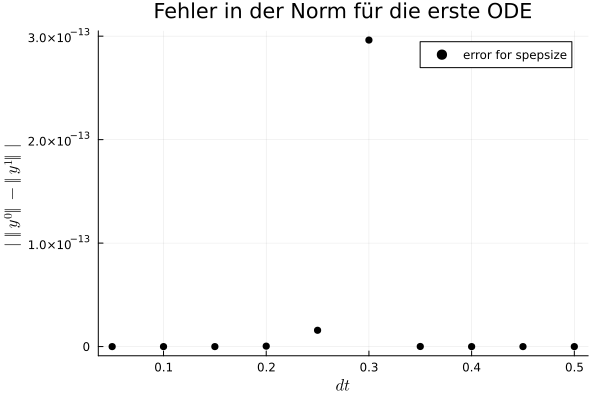

In [31]:
plot_firstode()

It looks like the method is having $\mathcal{J}$ as an invariant.
Now the question is: Is the method having $\mathcal{J}$ as an invariant in general? For this I will do the same procedure with a second ODE.

### Analyzing the method for the second ODE

$$ 
y' (t) = \frac{1}{2 + y_1(t)}
\left( \begin{matrix}
-y_2(t) \\
y_1(t)
\end{matrix} \right) = f(y)  $$

Then we get for $y''=f'(y)f(y)$:

$$ 
y''(t) = 
\left( \begin{matrix}
\frac{y_2 (t)}{\big( 2 + y_1(t) \big)^2} & - \frac{1}{ 2 + y_1(t)}\\
 \frac{ 2}{\big( 2 + y_1(t) \big)^2} & 0
\end{matrix} \right) \cdot f(y)
= \left( \begin{matrix}
- \frac{y_1(t) \big(2 + y_1(t)\big) + y_2(t)^2}{\big(2+ y_1(t)\big)^3} \\
- \frac{2y_2(t)}{\big(2+ y_1(t)\big)^3}
\end{matrix} \right) $$

Now I define the functions $f$ and $g$.

In [32]:
function f2(y)
    factor = 1/(2+y[1])
    dy = zero(y)
    dy[1] = -factor * y[2]
    dy[2] =  factor * y[1]
    return dy
end

f2 (generic function with 1 method)

In [33]:
function g2(y)
    factor = 1/(2+y[1])^3
    ddy = zero(y)
    ddy[1] = -factor * (y[1] * (2 + y[1]) + y[2]^2)
    ddy[2] = -factor * (2 * y[2])
    return ddy
end

g2 (generic function with 1 method)

Calculating the new value $y^1$ with the method to check if $\mathcal{J}(y)=||y||^2$ is an invariant of the method.

In [34]:
function plot_secondode()
    y = [1.,0.]
    dt_values = [1/20, 2/20, 3/20, 4/20, 5/20, 6/20, 7/20, 8/20, 9/20, 10/20]

    dy2 = f2(y)
    ddy2 = g2(y)
    dy2, ddy2
    
    norm_error2 = zeros(length(dt_values))
    j = 1
    for dt in dt_values
        a = y + (1 / 2) * dt * dy2 + (1 / 12) * dt^2 * ddy2
    
        res = nlsolve(a; ftol = 1.0e-12) do residual, y_new
            dy2_new = f2(y_new)
            ddy2_new = g2(y_new)
            @. residual = a + (1 / 2) * dt * dy2_new - (1 / 12) * dt^2 *
            ddy2_new - y_new
            return nothing
        end
    norm_error2[j] = abs(norm(y) - norm(res.zero))
    j = j + 1
    end
    Plot2 = scatter(dt_values, norm_error2, title = "Fehler in der Norm für die zweite ODE", color = "black", xlabel = L"dt", ylabel = L"\mid \Vert y^0 \Vert - \Vert y^1 \Vert \mid", label="error for spepsize")
    savefig("Plot2.png")
    return Plot2
end

plot_secondode (generic function with 1 method)

Presenting the results in a plot by running plot_secondode().

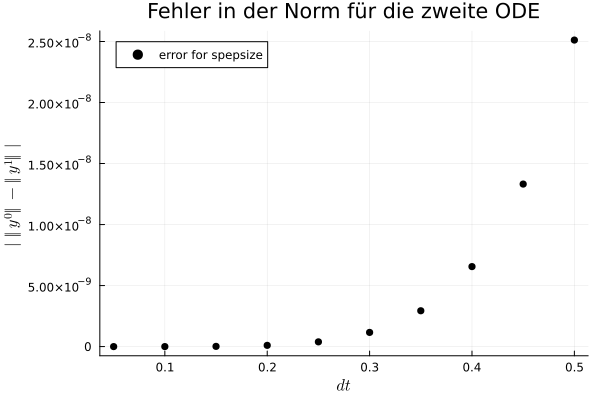

In [35]:
plot_secondode()

With the plot it is clear that the method is not having $\mathcal{J}$ as an invariant. 

Now let me check the symplecticity order of the method:

In [36]:
SymplecticityOrder(bseries_)

4

Since the symplecticity order is the same as the order of the method, the method randomly has $\mathcal{J}$ as an invariant for the first ODE. 
This leads to the following result: The method is not having quadratic invariants in general.    